### The aim is to check how cluster centroids are distributed in spaced
### and changed under global warming

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
from cartopy.util import add_cyclic_point


from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import NearestNDInterpolator,RegularGridInterpolator


import datetime as dt

import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import pandas as pd
from scipy.stats import norm
import os 
# import seaborn as sns
import cftime

%matplotlib inline

### Get names of all models you want to plot ###

In [2]:
!ls *.out

clusters_output_BCC-CSM2-MR_200201_201412.out
clusters_output_CNRM-CM6-1_200201_201412.out
clusters_output_CNRM-CM6-1_200501_201412.out
clusters_output_KACE-1-0-G_199001_199912.out
clusters_output_SSP585_BCC-CSM2-MR_209101_210012.out
clusters_output_SSP585_CNRM-CM6-1_209101_210012.out
clusters_output_SSP585_@KACE-1-0-G_209101_210012.out
clusters_output_TRMM3B42_200201_201412.out


### Enter a single model name into the list below ###

In [3]:
### KACE SSP only runs from 2095-2100, so we must be careful to only use temperature values from that range for scaling ###

In [4]:
obs_name=['TRMM3B42_200201_201412']

model_out_files=[['BCC-CSM2-MR_200201_201412','BCC-CSM2-MR_209101_210012'],
            ['KACE-1-0-G_199001_199912','@KACE-1-0-G_209101_210012'],
            ['CNRM-CM6-1_200201_201412','CNRM-CM6-1_209101_210012']]

model_names_HIST=[i[0] for i in model_out_files]
model_names_SSP=['SSP585_'+i[1] for i in model_out_files] ## adding the SSP585 prefix to all models 
model_names=[i[0].split('_')[0] for i in model_out_files]
model_names

['BCC-CSM2-MR', 'KACE-1-0-G', 'CNRM-CM6-1']

### Read cluster info ###

In [5]:
dirc_hist="/home/fiaz/cluster_analysis/"
fil_hist=[]
for i in model_names_HIST:
    fil_hist.append(list(glob(dirc_hist+'clusters_output_'+i+'*'))[0])
fil_hist.sort()
fil_hist

['/home/fiaz/cluster_analysis/clusters_output_BCC-CSM2-MR_200201_201412.out',
 '/home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_200201_201412.out',
 '/home/fiaz/cluster_analysis/clusters_output_KACE-1-0-G_199001_199912.out']

In [6]:
def read_files (dirc,name,cluster_dict):
    file_path=dirc+'clusters_output_'+name+'.out'
    print('Reading '+file_path)
    print(file_path)
    file_name=glob(file_path)[0]
    with open(file_name, 'rb') as handle:
        cluster_dict[name] = pickle.load(handle)
    

In [7]:
### set the directory names for obs, hist and ssp; same in this case ###
dirc_obs="/home/fiaz/cluster_analysis/"
dirc_hist="/home/fiaz/cluster_analysis/"
dirc_ssp="/home/fiaz/cluster_analysis/"

direc_SSP="/home/fiaz/cluster_analysis/"
direc_HIST="/home/fiaz/cluster_analysis/"

# direc_SSP="/home/leilanid/"
# direc_HIST="/home/leilanid/Clusters/CMIP6 Files/"

In [8]:
model_names_HIST

['BCC-CSM2-MR_200201_201412',
 'KACE-1-0-G_199001_199912',
 'CNRM-CM6-1_200201_201412']

In [9]:
### read all the info into the cluster_dict ###
cluster_dict={}
read_files(dirc_obs,obs_name[0],cluster_dict)
for i,j in zip(model_names_HIST,model_names_SSP):
    read_files(dirc_hist,str(i),cluster_dict)
    read_files(dirc_ssp,str(j),cluster_dict)
    print('--------------------')

Reading /home/fiaz/cluster_analysis/clusters_output_TRMM3B42_200201_201412.out
/home/fiaz/cluster_analysis/clusters_output_TRMM3B42_200201_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_BCC-CSM2-MR_200201_201412.out
/home/fiaz/cluster_analysis/clusters_output_BCC-CSM2-MR_200201_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_BCC-CSM2-MR_209101_210012.out
/home/fiaz/cluster_analysis/clusters_output_SSP585_BCC-CSM2-MR_209101_210012.out
--------------------
Reading /home/fiaz/cluster_analysis/clusters_output_KACE-1-0-G_199001_199912.out
/home/fiaz/cluster_analysis/clusters_output_KACE-1-0-G_199001_199912.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_@KACE-1-0-G_209101_210012.out
/home/fiaz/cluster_analysis/clusters_output_SSP585_@KACE-1-0-G_209101_210012.out
--------------------
Reading /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_200201_201412.out
/home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_200201_201412.out
Read

In [10]:
cluster_dict.keys()

dict_keys(['TRMM3B42_200201_201412', 'BCC-CSM2-MR_200201_201412', 'SSP585_BCC-CSM2-MR_209101_210012', 'KACE-1-0-G_199001_199912', 'SSP585_@KACE-1-0-G_209101_210012', 'CNRM-CM6-1_200201_201412', 'SSP585_CNRM-CM6-1_209101_210012'])

### Create dummy latitude-longitude ###

In [11]:
lat_dummy=np.arange(-30,35,5.)
lon_dummy=np.arange(-180,180,5)
dummy_data=np.zeros((lat_dummy.size,lon_dummy.size))
dummy_data[:]=np.sqrt(abs(lon_dummy[None,:]))

### Functions to count clusters inside each gridbox ###

In [12]:
def extract_grid_info(dict_input):
    
    sizes=dict_input['sizes']
    sz=(sizes[:-1]+sizes[1:])*0.5
    sz_diff=np.diff(sizes)   
    
    precip_cluster_power_scale=dict_input['precip_cluster_power_scale']
    pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
    pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
    
    pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)

    power_scale=dict_input['precip_cluster_power_scale']
    pixels_to_area=dict_input['pixels_to_area']

    return sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale,pixels_to_area


def extract_com_info(cluster_dict,pthresh,lat,lon,pow_thresh):
    centroid_info=cluster_dict['cluster_centroid_coords'][pthresh]
    lat_indx=np.int_((centroid_info[0,:]-(lat[0]))/np.diff(lat)[0])
    lon_indx=np.int_((centroid_info[1,:]-(lon[0]))/np.diff(lon)[0])
    
    sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale, pixels_to_area=extract_grid_info(cluster_dict)

    pcp_sizes=cluster_dict['pcp_sizes'][pthresh]*pixels_to_area
    pcp_power=cluster_dict['pcp_power'][pthresh]

    ind_select=np.where(pcp_power>pow_thresh)    
    ret=np.histogram2d(lat_indx[ind_select],lon_indx[ind_select],[np.arange(lat.size+1),np.arange(lon.size+1)])
    return ret[0]

### From SO to give scientific representation ##
def as_sci(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

In [13]:
model_names_HIST

['BCC-CSM2-MR_200201_201412',
 'KACE-1-0-G_199001_199912',
 'CNRM-CM6-1_200201_201412']

In [15]:
pthresh_list=[1.0]

In [16]:
pow_thresh=2e6
centroid_info={}
centroid_counts={}
centroid_diff={}


key=obs_name[0]
centroid_counts[key]=extract_com_info(cluster_dict[key],pthresh_list[0],
                 lat_dummy,lon_dummy,pow_thresh)


for n,(i,j) in enumerate(zip(model_names_HIST,model_names_SSP)):
    print(model_names[n],i,j)
    centroid_counts[i]=extract_com_info(cluster_dict[i],pthresh_list[0],
                     lat_dummy,lon_dummy,pow_thresh)

    centroid_counts[j]=extract_com_info(cluster_dict[j],pthresh_list[0],
                 lat_dummy,lon_dummy,pow_thresh)

    centroid_diff[model_names[n]]=centroid_counts[j]-centroid_counts[i]


BCC-CSM2-MR BCC-CSM2-MR_200201_201412 SSP585_BCC-CSM2-MR_209101_210012
KACE-1-0-G KACE-1-0-G_199001_199912 SSP585_@KACE-1-0-G_209101_210012
CNRM-CM6-1 CNRM-CM6-1_200201_201412 SSP585_CNRM-CM6-1_209101_210012


### Plot TRMM cluster density ###

<ipython-input-17-4ec3ca96dded>:34: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


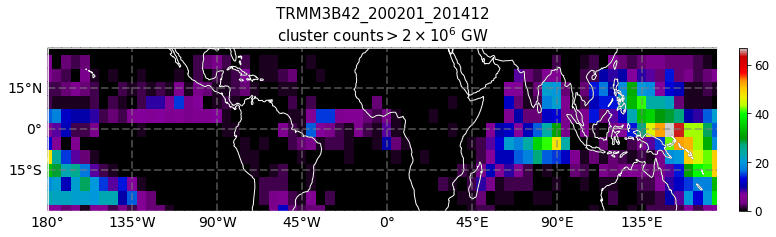

In [17]:
fig,axx = plt.subplots(1,1,figsize=(12, 3),subplot_kw={'projection': ccrs.PlateCarree()},
                      constrained_layout=False)
key=obs_name[0]
ax=axx
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180),figsize=(12,6))
ax.coastlines()

ax.set_extent([lon_dummy[0],lon_dummy[-1],lat_dummy[0],lat_dummy[-1]], crs=ccrs.PlateCarree())
CT=ax.pcolormesh(lon_dummy,lat_dummy,centroid_counts[key], 
             cmap=plt.get_cmap('nipy_spectral'),
             transform=ccrs.PlateCarree())
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='',format='%.0f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('%s\ncluster counts$>{0:s}$ GW'.format(as_sci(pow_thresh,0))%(key),fontsize=15)
ax.outline_patch.set_edgecolor('white')
ax.add_feature(cartopy.feature.COASTLINE,edgecolor='white')



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,15))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"TRMM_cluster_density"+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')
    print('plot saved as {}'.format(save_fig_name))

### Plot HIST and SSP ###

In [18]:
## adjust this parameter according to full range of cluster count values ###
max_counts=500

### choose model name here ##
key_hist=model_names_HIST[0]
key_ssp=model_names_SSP[0]
key_model=model_names[0]

<ipython-input-19-46d4c44581d0>:33: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')
<ipython-input-19-46d4c44581d0>:80: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')
<ipython-input-19-46d4c44581d0>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-19-46d4c44581d0>:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


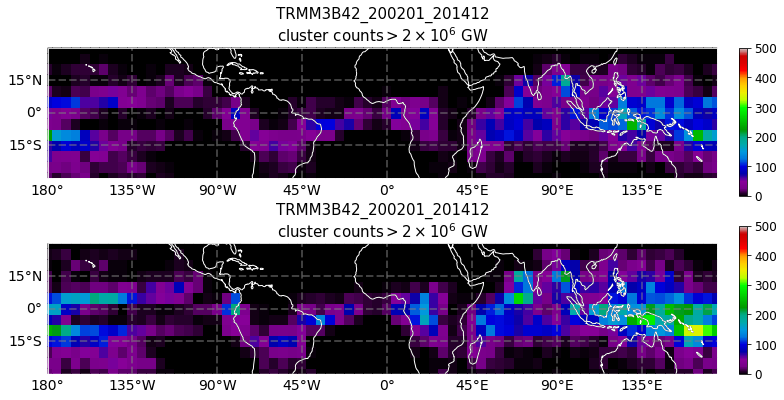

In [19]:
fig,axx = plt.subplots(2,1,figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree()},
                      constrained_layout=False)
ax=axx[0]
ax.coastlines()

ax.set_extent([lon_dummy[0],lon_dummy[-1],lat_dummy[0],lat_dummy[-1]], crs=ccrs.PlateCarree())
CT=ax.pcolormesh(lon_dummy,lat_dummy,centroid_counts[key_hist],
                 vmin=0, vmax=max_counts,
             cmap=plt.get_cmap('nipy_spectral'),
             transform=ccrs.PlateCarree())
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='',format='%.0f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('%s\ncluster counts$>{0:s}$ GW'.format(as_sci(pow_thresh,0))%(key),fontsize=15)
ax.outline_patch.set_edgecolor('white')
ax.add_feature(cartopy.feature.COASTLINE,edgecolor='white')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,15))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}




ax=axx[1]
ax.coastlines()

ax.set_extent([lon_dummy[0],lon_dummy[-1],lat_dummy[0],lat_dummy[-1]], crs=ccrs.PlateCarree())
CT=ax.pcolormesh(lon_dummy,lat_dummy,centroid_counts[key_ssp],
                  vmin=0, vmax=max_counts,
             cmap=plt.get_cmap('nipy_spectral'),
             transform=ccrs.PlateCarree())
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='',format='%.0f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('%s\ncluster counts$>{0:s}$ GW'.format(as_sci(pow_thresh,0))%(key),fontsize=15)
ax.outline_patch.set_edgecolor('white')
ax.add_feature(cartopy.feature.COASTLINE,edgecolor='white')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,15))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}



plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"cluster_counts_%s_%s"%(key_hist,key_ssp)+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')
    print('plot saved as {}'.format(save_fig_name))

In [20]:
### check to see if total clusters in ssp exceed hist ##
centroid_counts[key_hist].sum(),centroid_counts[key_ssp].sum()

(20135.0, 30529.0)

In [21]:
def plot_cluster_diff(ax,model_name,centroid_diff,plt_colorbar=False):
    
    ax.coastlines()
    ax.set_extent([lon_dummy[0],lon_dummy[-1],lat_dummy[0],lat_dummy[-1]], crs=ccrs.PlateCarree())
    CT=ax.pcolormesh(lon_dummy,lat_dummy,centroid_diff,
                      vmin=-max_counts_diff, vmax=max_counts_diff,
                 cmap=plt.get_cmap('RdBu_r'),
                 transform=ccrs.PlateCarree())
    ax.set_aspect('auto')
    
    if plt_colorbar:

        axpos = ax.get_position()
        pos_x = axpos.x0+axpos.width*1.15 #+ 0.05# + 0.25*axpos.width
        pos_y = axpos.y0+axpos.height*0.16
        cax_width = 0.01
        cax_height = axpos.height*0.75

        #create new axes where the colorbar should go.
        #it should be next to the original axes and have the same height!
        pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
        plt.colorbar(CT, cax=pos_cax,label='',format='%.0f')
        font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
        pos_cax.yaxis.label.set_font_properties(font)
        pos_cax.tick_params(which='both',labelsize=12.)


    ax.set_title(model_name,fontsize=14)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    gl.xlines = True
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,15))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    return CT

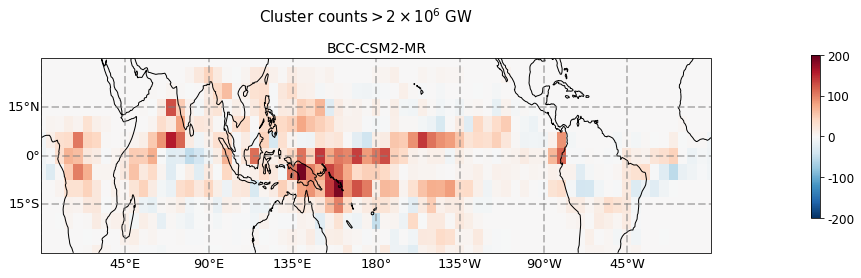

In [22]:
##
max_counts_diff=200
fig,axx = plt.subplots(1,1,figsize=(12, 4),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)
ax=axx
plot_cluster_diff(ax,key_model,centroid_diff[key_model],plt_colorbar=True)
fig.suptitle('Cluster counts$>{0:s}$ GW'.format(as_sci(pow_thresh,0)),
             fontsize=15)

plt.subplots_adjust(top=0.8,hspace=0.5)


# plt.tight_layout()
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"difference_cluster_counts_%s_%s"%(key_hist,key_ssp)+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')
    print('plot saved as {}'.format(save_fig_name))

### Present multiple model differences on the same plot ###

Auto-adjusts number of rows depending on number of models

In [24]:
model_names

['BCC-CSM2-MR', 'KACE-1-0-G', 'CNRM-CM6-1']

<ipython-input-27-4c4896295f0a>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-27-4c4896295f0a>:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


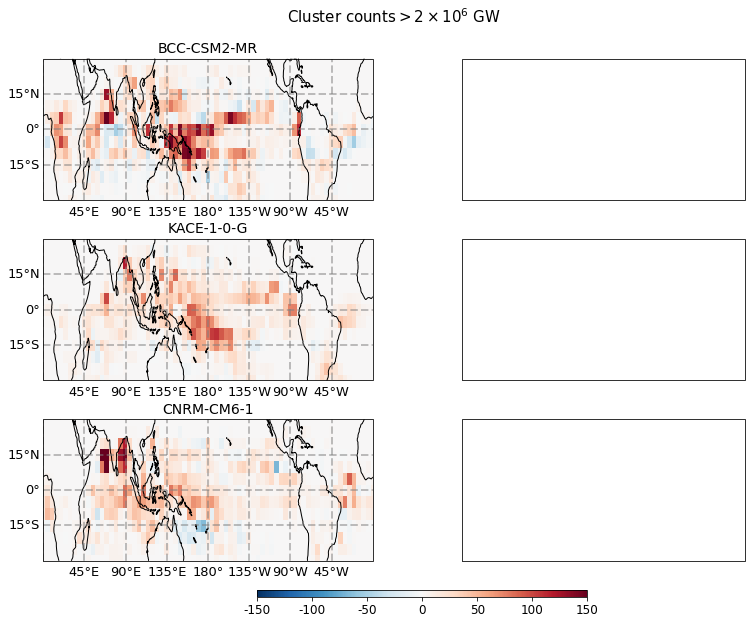

In [27]:
fig,axx = plt.subplots(len(model_names),2,figsize=(13, len(model_names)*3 ),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)
# plot_cluster_diff(ax,key_model,centroid_diff[key_model],plt_colorbar=True)

max_counts_diff=150
for n,model in enumerate(model_names):
    ax=axx[n,0]
    CT=plot_cluster_diff(ax,model,centroid_diff[model],plt_colorbar=False)


axpos = ax.get_position()
pos_x = axpos.x0+axpos.width*0.65 #+ 0.05# + 0.25*axpos.width
pos_y = axpos.y0-axpos.height*0.25
cax_width = axpos.width
cax_height = axpos.height*0.05

#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='',format='%.0f',
             orientation='horizontal')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)
        
fig.suptitle('Cluster counts$>{0:s}$ GW'.format(as_sci(pow_thresh,0)),
             fontsize=15)

plt.subplots_adjust(hspace=0.275,top=0.9)


plt.tight_layout()
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"multi_model_difference_cluster_counts.pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')
    print('plot saved as {}'.format(save_fig_name))